(300, 480, 3)


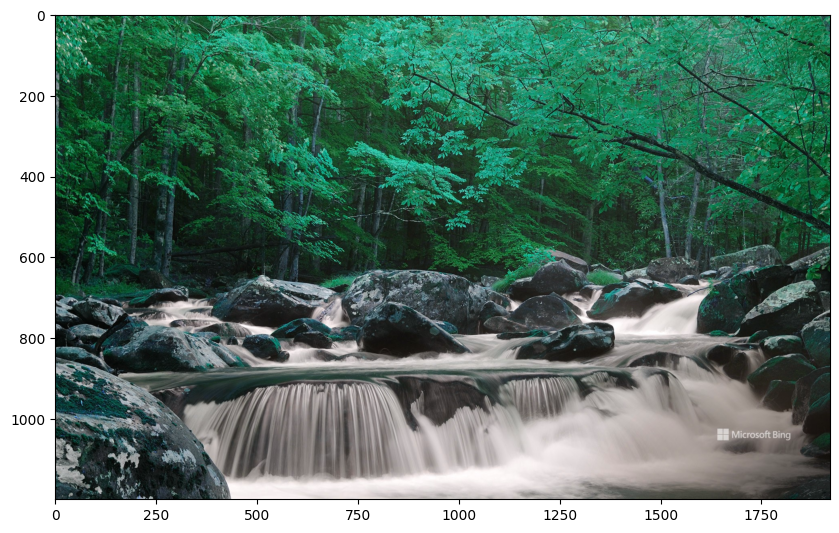

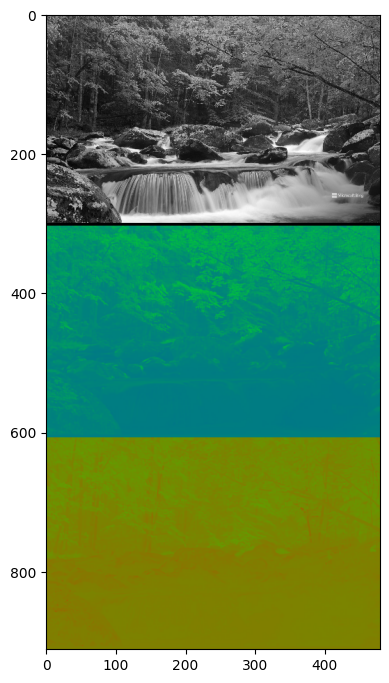

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from TCAM_simulator import TCAMSimulator
import point_encoder
import interval_encoder
import json
BIT_DEPTH=6
INTERVAL=8
BLOCK_SIZE=8

img = cv2.imread('BingWallpaper.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(img)
img=img[::4,::4,:]
print(img.shape)

height, width = img.shape[:2]
new_height = (height + BLOCK_SIZE - 1) // BLOCK_SIZE * BLOCK_SIZE
new_width = (width + BLOCK_SIZE - 1) // BLOCK_SIZE * BLOCK_SIZE

padded_img = np.zeros((new_height, new_width, 3), dtype=img.dtype)
padded_img[:height, :width] = img
img = padded_img

def make_lut_u():
    return np.array([[[i,255-i,0] for i in range(256)]],dtype=np.uint8)

def make_lut_v():
    return np.array([[[0,255-i,i] for i in range(256)]],dtype=np.uint8)

def make_lut_Y():
    return np.array([[[i, i, i] for i in range(256)]], dtype=np.uint8)

img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
Y, U, V = cv2.split(img_yuv)

lut_u, lut_v,lut_Y = make_lut_u(), make_lut_v(), make_lut_Y()

def display(Y, U, V):
    # Convert back to BGR so we can apply the LUT and stack the images
    Y = cv2.cvtColor(Y, cv2.COLOR_GRAY2BGR)
    U = cv2.cvtColor(U, cv2.COLOR_GRAY2BGR)
    V = cv2.cvtColor(V, cv2.COLOR_GRAY2BGR)

    y_mapped= cv2.LUT(Y, lut_Y)
    u_mapped = cv2.LUT(U, lut_u)
    v_mapped = cv2.LUT(V, lut_v)

    result = np.vstack([ y_mapped, u_mapped, v_mapped])
    plt.figure(figsize=(4, 10))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.tight_layout()

display(Y, U, V)
U=U[::2,::2]
V=V[::2,::2]

In [2]:
def encode_grayscale(Y):
    blocks = [
        Y[i:i+BLOCK_SIZE, j:j+BLOCK_SIZE].flatten()
        for i in range(0, Y.shape[0], BLOCK_SIZE)
        for j in range(0, Y.shape[1], BLOCK_SIZE)
    ]
    sample_entry=interval_encoder.encode_block_interval(blocks[0], BIT_DEPTH,INTERVAL)
    width= len(sample_entry)
    print(f"Sample TCAM entry (len={width}):", sample_entry)
    TCAM= TCAMSimulator(width)
    tcam_entrys = []
    for idx,block in tqdm(enumerate(blocks),total=len(blocks)):
        entry=interval_encoder.encode_block_interval(block, BIT_DEPTH,INTERVAL)
        entry = [x if x != '*' else 'X' for x in entry]
        tcam_entrys.append(TCAM.write(pattern=entry, value=idx,priority=0))
    return TCAM,tcam_entrys

TCAM_Y,entries_Y=encode_grayscale(Y)
TCAM_U,entries_U=encode_grayscale(U)
TCAM_V,entries_V=encode_grayscale(V)

Sample TCAM entry (len=640): 100*1*****101***1***111*1*****111*1*****101*****1*1101*****11*10*****011*1**0***1011**1***111**1****110*******1110******110***0***1001******1*00******11*1****0*1*10******1*100*****10*1****0*101*1*****1100******10*1*****01000******100*1*****100*******10*****1**11*1*0****1*00***0**111****1**1101*****1100***1***110***1***1*00******101***1***11*1*0****1100*******10*****0*1*00****0*110**0****10*1****0*1*1****0**10*1***0**101*****1*10******1*1*1******01*00***0**11*10*****1*1****0**111*******111*1*****110***1***1100*****110*1*****01010******1010******11*1**0***10***1****1*0***0***1*100*****1*0**0****1011******110*0*****111*****1*1111******


100%|██████████| 2280/2280 [00:01<00:00, 1323.87it/s]


Sample TCAM entry (len=640): 11*1****0*111**1****101**1****1010******101**1****111*******100*******101***1***111*****1*11*1***0**10*1*0****11*1****0*1*10*****01*10***0**1*100*****10*1**0***1010******1*10******10*1**0***110***1***11*1*****01*100*****1*10***0**1011******101**1****1*100*****111*1*****100****1**1*10***0**1110******1*10***0**111*******10*10*****101***1***1110******111****1**111**1****1110******111**1****10*1**0***101*1*****10*1*0****10*1**0***1111******101*****1*111*******1110******1110******101****1**1*10******101***1***10*1*****011*1****0*111*******11*1******101*****1*1*000*****101*******1110******111******1100****1**1*10***0**111**1****1*10*0****


100%|██████████| 570/570 [00:00<00:00, 1621.37it/s]


Sample TCAM entry (len=640): 101***1***101**1****10*1*0****100*1*****10*1*0****1001******1*00******1*00*****0100***1***10*10*****10*10*****1001******10*10*****10*1*0****100*1*****1*000*****10*1*****010*1******100*1*****100**1****10*1*****010*1*0****101*****1*10*1******10*10*****101*****1*10*1******100***1***10*1*0****1001******100*******1001******10*1*****0101*1*****100***1***1001******10*1*0****10*1***0**10*1***0**100*1*****1010******100*1*****1000******10*10*****10*1*0****10*1*0****10*1*****0101******1100**1****10*1*0****1*10****0*100****1**100****1**10*1******1001******101******1100**1****10*1***0**10*1******101******1100****1**10*1*****010*1*0****101*****1*


100%|██████████| 570/570 [00:00<00:00, 1619.35it/s]


In [3]:
def find_match(TCAM:TCAMSimulator,Y,entries_Y):
    width=TCAM.width
    blocks = [
        Y[i:i+BLOCK_SIZE, j:j+BLOCK_SIZE].flatten()
        for i in range(0, Y.shape[0], BLOCK_SIZE)
        for j in range(0, Y.shape[1], BLOCK_SIZE)
    ]
    matches=np.zeros(len(blocks), dtype=int)
    for idx,block in tqdm(enumerate(blocks),total=len(blocks)):
        entry=point_encoder.encode_block_point(block, BIT_DEPTH,INTERVAL)
        TCAM.change_priority(entries_Y[idx], new_priority=100)
        match=TCAM.search(entry)
        TCAM.change_priority(entries_Y[idx], new_priority=0)
        matches[idx] = match
    return matches

matches_U = find_match(TCAM_U, U, entries_U)
matches_V = find_match(TCAM_V, V, entries_V)
matches_Y = find_match(TCAM_Y, Y, entries_Y)

100%|██████████| 2280/2280 [00:03<00:00, 658.29it/s]


In [4]:
total_entries= len(entries_Y) + len(entries_U) + len(entries_V)
total_bits= TCAM_Y.width*len(entries_Y)+ TCAM_U.width*len(entries_U)+TCAM_V.width*len(entries_V)
print(f"Total TCAM entries: {total_entries}")
print(f"Total TCAM bits: {total_bits}")
TCAM_simu=[  {
    "id": "Y",
    "step": 0,
    "match": "ternary",
    "entries": len(entries_Y),
    "key_size": TCAM_Y.width
  },
    {
    "id": "U",
    "step": 0,
    "match": "ternary",
    "entries": len(entries_U),
    "key_size": TCAM_U.width
  },
    {
    "id": "V",
    "step": 0,
    "match": "ternary",
    "entries": len(entries_V),
    "key_size": TCAM_V.width
  }]

with open("image_compression.json", "w") as f:
    json.dump(TCAM_simu, f, indent=4)

import sim
sim.main(['',"image_compression.json"])

Total TCAM entries: 3420
Total TCAM bits: 2188800
TCAM mapping: 
[24, 24, 24, 24, 24, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SRAM mapping: 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
id mapping: 
[['Y'], ['Y'], ['Y'], ['Y', 'U'], ['U', 'V'], ['V'], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


(304, 480)


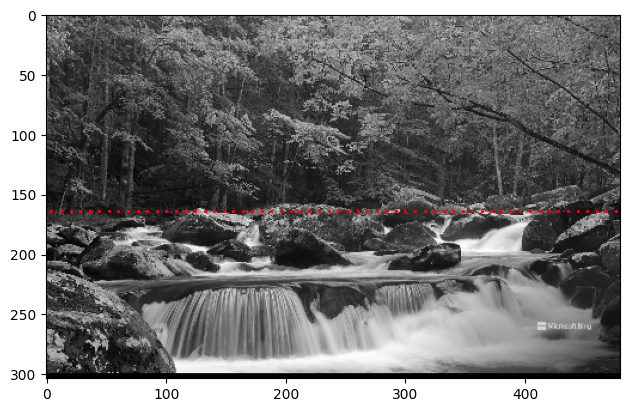

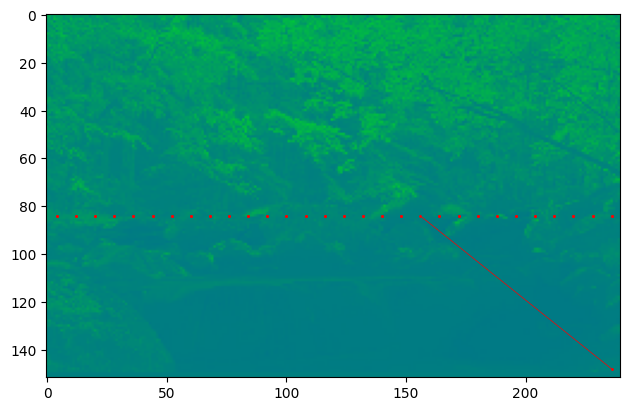

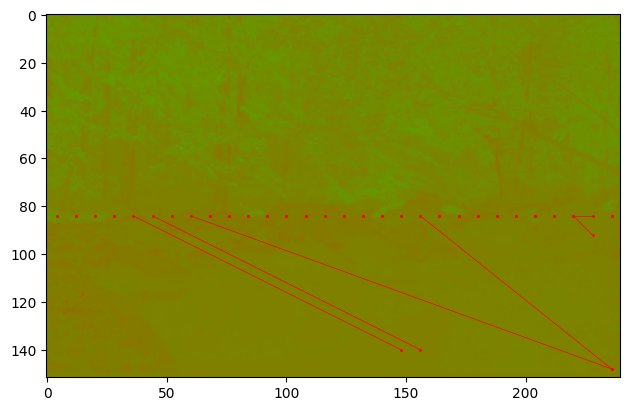

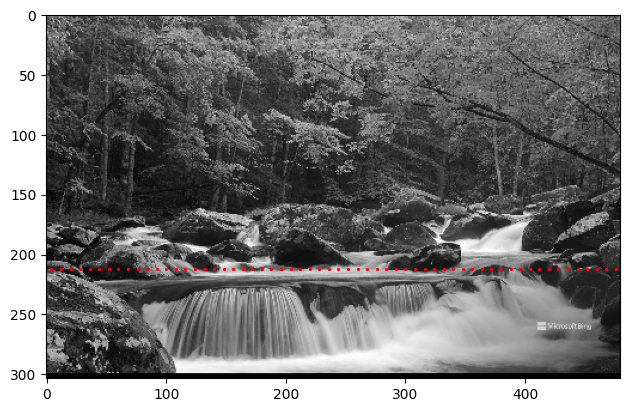

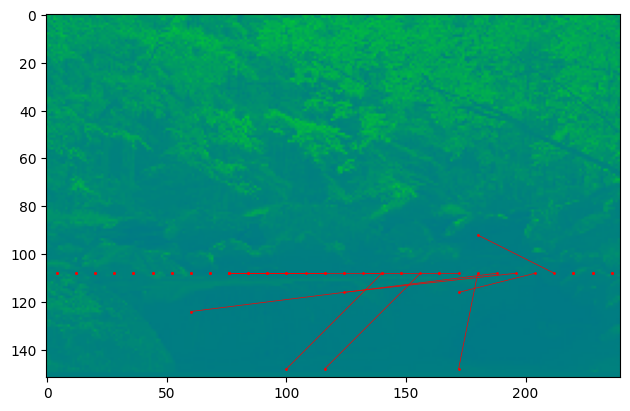

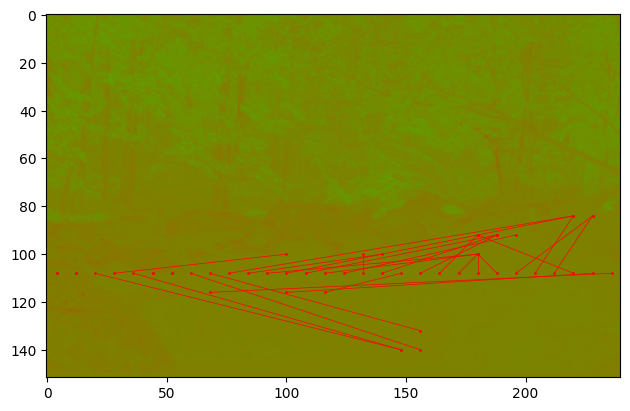

In [5]:
def plot_match(Y,matches,LUT,row=4):
    idx=0
    idx_to_position={}
    for i in range(0, Y.shape[0], BLOCK_SIZE):
        for j in range(0, Y.shape[1], BLOCK_SIZE):
            idx_to_position[idx]= (i, j)
            idx += 1
    y_mapped= cv2.LUT(cv2.cvtColor(Y, cv2.COLOR_GRAY2BGR), LUT)
    plt.figure()
    plt.imshow(cv2.cvtColor(y_mapped, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    idx=0
    for i in range(0, Y.shape[0], BLOCK_SIZE):
        for j in range(0, Y.shape[1], BLOCK_SIZE):
            match = matches[idx]
            idx += 1
            if i//BLOCK_SIZE!=row:
                continue
            match_i, match_j = idx_to_position[match]
            center_i, center_j = i + BLOCK_SIZE // 2, j + BLOCK_SIZE // 2
            match_center_i, match_center_j = match_i + BLOCK_SIZE // 2, match_j + BLOCK_SIZE // 2
            plt.plot([center_j, match_center_j], [center_i, match_center_i], color='red', linewidth=0.5,marker='o', markersize=1)

print(Y.shape)
plot_match(Y, matches_Y, lut_Y,20)
plot_match(U, matches_U, lut_u,10)
plot_match(V, matches_V, lut_v,10)
plot_match(Y, matches_Y, lut_Y,26)
plot_match(U, matches_U, lut_u,13)
plot_match(V, matches_V, lut_v,13)

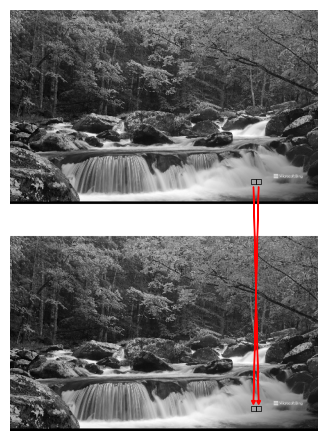

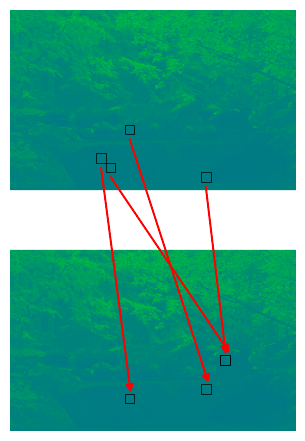

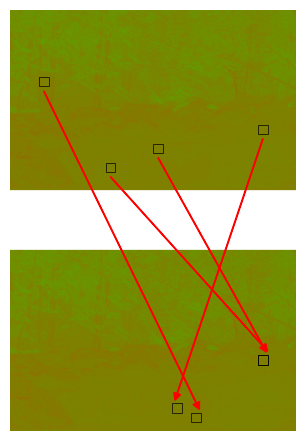

In [8]:
def get_center(n, dim_y):
    num_block_y = dim_y // BLOCK_SIZE
    i = n // num_block_y
    j = n % num_block_y
    return i * BLOCK_SIZE + BLOCK_SIZE // 2, j * BLOCK_SIZE + BLOCK_SIZE // 2

def plot_matches(Y,matches,LUT):
    border = 50
    y_mapped= cv2.LUT(cv2.cvtColor(Y, cv2.COLOR_GRAY2BGR), LUT)
    plt.figure()
    y_mapped= cv2.cvtColor(y_mapped, cv2.COLOR_BGR2RGB)
    y_combined = np.vstack([y_mapped, np.full((border, y_mapped.shape[1], y_mapped.shape[2]), 255, dtype=np.uint8), y_mapped])
    plt.imshow(y_combined)
    plt.tight_layout()
    
    ax = plt.gca()
    for match in matches:
        dim_y = Y.shape[1]
        (x1, y1), (x2, y2) = get_center(match[0], dim_y), get_center(match[1], dim_y)
        ax.add_patch(patches.FancyArrow(y1, x1+BLOCK_SIZE, y2-y1, x2+Y.shape[0]+border-x1-2.5*BLOCK_SIZE,
                                width=0.5, head_width=6, head_length=6, color='red'))
        rect = patches.Rectangle((y1-BLOCK_SIZE//2, x1-BLOCK_SIZE//2), BLOCK_SIZE, BLOCK_SIZE, linewidth=0.5, edgecolor='black',facecolor='none')
        ax.add_patch(rect)
        rect = patches.Rectangle((y2-BLOCK_SIZE//2, x2+Y.shape[0]+border-BLOCK_SIZE//2), BLOCK_SIZE, BLOCK_SIZE, linewidth=0.5, edgecolor='black',facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

good_matches_Y = []
for i, match in enumerate(matches_Y):
    if i != match:
        good_matches_Y.append((i, match))
plot_matches(Y, good_matches_Y[:2], lut_Y)

good_matches_U = []
for i, match in enumerate(matches_U):
    if i != match:
        good_matches_U.append((i, match))
U_indices = [5, 64, 40, 96]
plot_matches(U, [good_matches_U[i] for i in U_indices], lut_u)

good_matches_V = []
for i, match in enumerate(matches_V):
    if i != match:
        good_matches_V.append((i, match))
V_indices = [40, 80, 125, 0]
plot_matches(V, [good_matches_V[i] for i in V_indices], lut_v)